In [3]:
import matplotlib.pyplot as plt
import fasttext

from os import chdir
chdir('../DB')
from setting import METRIC_TYPE
from vector_db import MilvusCollection
from relational_db import SQLiteDB
from towhee import AutoConfig, AutoPipes
from loguru import logger
from json import load
from numpy import array, argpartition


data_path = '../data/MLQA_query_keywords_en.json'
# data_path = '../data/MLQA_query_keywords_zh.json'
collection_name = 'MLQA_BART_keywords'
partition = 'en'

collection = MilvusCollection(collection_name)
sqlite_db = SQLiteDB('context')

if partition == 'en':
    config = AutoConfig.load_config('sentence_embedding')
    config.model = 'average_word_embeddings_glove.6B.300d'
    sentence_embedding = AutoPipes.pipeline('sentence_embedding', config=config)
elif partition == 'zh':
    ft = fasttext.load_model('../data/cc.zh.300.bin')
else:
    raise NotImplementedError

/home/kelve/anaconda3/envs/COMP87project/lib/python3.11/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [1]:
import fasttext


ft = fasttext.load_model('../data/cc.zh.300.bin')
print(ft.get_word_vector('颜色'))

[ 9.88919958e-02  1.44844189e-01  4.06740278e-01 -6.30361959e-02
  5.00120223e-03  1.00733668e-01  1.05737178e-02 -9.56025124e-02
 -3.67987722e-01  1.24359562e-03  9.07852650e-02 -4.12391387e-02
  2.28176400e-01  1.08465962e-01 -1.40495881e-01  8.81702751e-02
 -2.07814686e-02  1.96747426e-02  1.26886576e-01  1.43244952e-01
 -1.39250383e-01  1.17291093e-01 -1.53971463e-01  5.01590520e-02
  4.76615727e-02 -2.94981543e-02 -2.43105087e-02 -1.48372680e-01
 -9.73486975e-02  1.89616323e-01 -2.87899762e-01 -3.49086784e-02
  7.04803094e-02 -4.55900282e-02  8.05896148e-03  1.64363459e-01
 -5.38677387e-02 -1.38043463e-01  1.15684960e-02 -1.54708669e-01
  1.21663868e-01 -2.22720668e-01  1.27078712e-01  1.48251712e-01
  1.67589679e-01  1.65740058e-01  5.31339884e-01  1.71442971e-01
  3.03283092e-02  1.22007132e-01 -9.50722918e-02  3.67125161e-02
 -1.02389731e-01  5.91663904e-02  1.52862579e-01 -1.27518296e-01
  2.69321084e-01 -9.09134746e-02  1.32263582e-02 -2.48327293e-02
 -7.26403296e-02  4.96992

In [1]:
from loguru import logger

logger.debug("Loading data from '" + data_path + "'")

with open(data_path, 'r') as file:
    queries = load(file)

logger.debug("Data from '" + data_path + "' loaded")
logger.debug("Generating embeddings")

keywords = []
list_weights = [None] * len(queries)

for i, query in enumerate(queries):
    kws = query['keywords']
    if 'prob' in query:
        prob = query['prob']
        s = sum(prob)
        list_weights[i] = [p / s for p in prob]
    else:
        length = len(kws)
        list_weights[i] = [1. / length] * length
    keywords += kws

if partition == 'en':
    embeddings = [embedding.get()[0] for embedding in sentence_embedding.batch(keywords)]
elif partition == 'zh':
    embeddings = [ft.get_word_vector(keyword) for keyword in keywords]


logger.debug("Embeddings generated")
logger.debug("Searching in partition <" + partition + "> from collection <" + collection_name + '>')

NameError: name 'data_path' is not defined

In [4]:
search_params = {
    "metric_type": METRIC_TYPE,
    "params": {
        # search for vectors with a distance greater than 0.8
        "radius": 0.8
    }
}

logger.debug("Loading data from '" + data_path + "'")

with open(data_path, 'r') as file:
    queries = load(file)

logger.debug("Data from '" + data_path + "' loaded")
logger.debug("Generating embeddings")

keywords = []
list_weights = [None] * len(queries)

for i, query in enumerate(queries):
    kws = query['keywords']
    if 'prob' in query:
        prob = query['prob']
        s = sum(prob)
        list_weights[i] = [p / s for p in prob]
    else:
        length = len(kws)
        list_weights[i] = [1. / length] * length
    keywords += kws

if partition == 'en':
    embeddings = [embedding.get()[0] for embedding in sentence_embedding.batch(keywords)]
elif partition == 'zh':
    embeddings = [ft.get_word_vector(keyword) for keyword in keywords]

logger.debug("Embeddings generated")
logger.debug("Searching in partition <" + partition + "> from collection <" + collection_name + '>')

length = len(embeddings)
results = [None] * length

i = 0

# 16384 is milvu's maximum search batch size
while i + 16384 < length:
    search_results = collection.search(embeddings[i:i + 16384], "embedding", search_params, 5, partition_names=[partition], output_fields=["context_ids"])
    
    for search_result in search_results:
        results[i] = search_result
        i += 1

search_results = collection.search(embeddings[i:], "embedding", search_params, 5, partition_names=[partition], output_fields=["context_ids"])
    
for search_result in search_results:
    results[i] = search_result
    i += 1

logger.debug("Searching completed")

recalls = []
recall = 0.
left_index = 0

for i, weights in enumerate(list_weights):
    score = {}
    for j, weight in enumerate(weights):
        result = results[left_index + j]
        for hit in result:
            distance = hit.distance
            for context_id in hit.context_ids:
                if context_id in score:
                    score[context_id] += weight * distance
                else:
                    score[context_id] = weight * distance
    
    length = len(score)
    
    if length < 6:
        keys = list(score.keys())
    else:
        values = array(list(score.values()))
        args = argpartition(values, -5)[-5:]
        keys = array(list(score.keys()))[args]
    
    context_id = queries[i]['context id']
    print(f"docs retrieved for query {i}: {keys} (expected: {context_id})")
    
    if context_id in keys:
        recall = (i * recall + 1) / (i + 1)
    else:
        recall *= i / (i + 1)
    
    # print("recall: ", recall)
    # print('\n')
    recalls.append(recall)
    left_index += len(weights)

print('recall = ', recall)

2024-03-02 09:46:42.934 | DEBUG    | __main__:<module>:9 - Loading data from '../data/MLQA_query_keywords_en.json'
2024-03-02 09:46:42.964 | DEBUG    | __main__:<module>:14 - Data from '../data/MLQA_query_keywords_en.json' loaded
2024-03-02 09:46:42.965 | DEBUG    | __main__:<module>:15 - Generating embeddings
2024-03-02 09:47:28.236 | DEBUG    | __main__:<module>:36 - Embeddings generated
2024-03-02 09:47:28.237 | DEBUG    | __main__:<module>:37 - Searching in partition <en> from collection <MLQA_BART_keywords>
2024-03-02 09:47:39.406 | DEBUG    | __main__:<module>:58 - Searching completed


docs retrieved for query 0: [2 3 1 4 5] (expected: 0)
docs retrieved for query 1: [1 4 5 6 0] (expected: 0)
docs retrieved for query 2: [2 5 1 4 3] (expected: 0)
docs retrieved for query 3: [0 4 1 2 7] (expected: 0)
docs retrieved for query 4: [0 4 1 2 7] (expected: 1)
docs retrieved for query 5: [4 1 5 2 6] (expected: 2)
docs retrieved for query 6: [0 4 1 2 7] (expected: 2)
docs retrieved for query 7: [0 4 1 2 7] (expected: 3)
docs retrieved for query 8: [4 1 3 5 6] (expected: 4)
docs retrieved for query 9: [2 1 6 5 7] (expected: 5)
docs retrieved for query 10: [5 3 1 2 4] (expected: 5)
docs retrieved for query 11: [4 1 3 5 6] (expected: 6)
docs retrieved for query 12: [2 1 3 5 6] (expected: 6)
docs retrieved for query 13: [2 4 1 3 7] (expected: 7)
docs retrieved for query 14: [  11 2881    9   12    8] (expected: 8)
docs retrieved for query 15: [   9 2881   13   12    8] (expected: 9)
docs retrieved for query 16: [  11 2881    9   12    8] (expected: 10)
docs retrieved for query 17: 

Text(0, 0.5, 'recall')

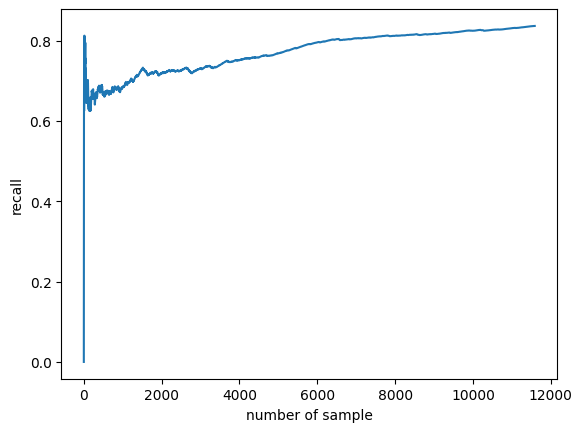

In [5]:
plt.plot(recalls)
plt.xlabel('number of sample')
plt.ylabel('recall')